In [99]:
import numpy as np
import meep as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from meep.materials import Cu # Recordatorio asi se importan materiales clasicos, la lista esta en meep/materaials.py leer si se quiere otro ejemplo Al, Au ...

In [100]:
# Parámetros geométricos
a = 2.54 # (mm) profundidad de la guia
b = 1.27 # (mm) ancho de la guia
L = 10.0 # (mm) altura de la guia
d = 0.74 # (mm) separación entre las guias principales
h = 0.2866 # (mm) ancho del brazo 
c = 0.74 # (mm) separación entre los brazos
n = 8 #numero de brazos 

# Conversión a unidades internas de Meep (1 unit = 1 mm)
um = 1.0
cell_x = L+1#d+b+3 * um
cell_y = 5 * um
cell_z = 5#a+2 * um
resolution = 50 # pts/mm Resoluciones bajas dan errores de INf o Nan en los ca,pos al pareceser necesita una alta densidad ed puntos por milimetro

# Banda de la fuente 
# pueden ser Banda 2: 67 - 90 Ghz, Banda3: 84 -116 GHz, Banda 2+3: 67-116
# dejando c=1 y unidades milimetricas como unidad principal es decir j=1 es 1mm
# para convertir primero comvierto la frecuencia en GHZ en longitud de onda en mm, usar \lamda = 300/f(GHz) (mm), luego f = 1/lambda, es decir f(UNIDADES MEEP) = f(GHz)/300 
# banda 2: 2.23 - 3, banda 3: 2.8 - 3.87, banda 2+3: 2.23 - 3.87  

fminima = 75
fmaxima = 110

fminima = fminima/ 300 # en milimetros
fmaxima = fmaxima/ 300 # en milimetros

fcentral  = (fminima + fmaxima)/2
df = (fminima - fmaxima)

nfreq = 100

In [103]:
# Fuente ubicada en uno de los extremos de la región 


sources = [
    mp.Source(
        mp.ContinuousSource(frequency=fcentral, fwidth = df), component=mp. Hz,size=(0, b,a) ,center=mp.Vector3(-L/2,(b+d)/2,  0),
    )
]

# monitores de flujo 

# lista de posiciones o regiones donde pones monitores
regions = [
    mp.FluxRegion(center=mp.Vector3(  L/2, (b+d)/2, 0), size=mp.Vector3 (0, b, a)),
    mp.FluxRegion(center=mp.Vector3(  L/2, -(b+d)/2, 0), size=mp.Vector3 (0, b, a)),
    mp.FluxRegion(center=mp.Vector3(  -L/2+0.5, (b+d)/2, 0), size=mp.Vector3 (0, b, a)),
]



In [104]:
k_point = mp.Vector3( fcentral, 0 , 0) # numero de onda en una onda plana, se distribuye en el eje X



In [105]:
def geometria(a,b,c,L,d,h,n):
    if n%2 == 0:
        # ————————————————————————————————
        # Definición de la geometría en "H"  para numero de brazos pares 
        m = int(n/2)
        mBrach = h*(m + 1) + c*(1/2 + m)
        
        if mBrach > L: # verificación de errores por numero excesivo de brazos
            print("numero de Brazos incorrecto, no capen en la altura de la guia dada")
            return
        
        geometry = [
            mp.Block(size = mp.Vector3(cell_x,cell_y,cell_z), # Cubo de Metal al rededor del hibrido 
                        center = mp.Vector3(0,0,0),
                        material = mp.metal),
            mp.Block(size=mp.Vector3( cell_x, b, a), # Conductos principales
                        center=mp.Vector3( 0, -(b+d)/2, 0), 
                        material=mp.air),
            mp.Block(size=mp.Vector3(cell_x, b,  a),
                        center=mp.Vector3(0, (b+d)/2, 0),
                        material=mp.air)] + [ 
            mp.Block(size=mp.Vector3(h, d, a), 
                    center=mp.Vector3( -(1+2*i)*(h+c)/2, 0, 0), # Brazos extra 
                    material=mp.air) for i in range(m) ] + [
            mp.Block(size=mp.Vector3( h, d, a), 
                    center=mp.Vector3((1+2*i)*(h+c)/2 , 0,  0), 
                    material=mp.air) for i in range(m)]
                    
        return geometry
        
        
    else:
        # ————————————————————————————————
        # Definición de la geometría en "H" para numero de brazos impares
        
        m = int((n-1)/2)
        mBrach = c*m + h*(m + 1/2)
        
        if mBrach > L: # verificación de errores por numero excesivo de brazos
            print("numero de Brazos incorrecto, no capen en la altura de la guia dada")
            return
            
        geometry = [
            mp.Block(size = mp.Vector3(cell_x,cell_y,cell_z),
                        center = mp.Vector3(0,0,0),
                        material = mp.metal), #Recubrimiento, Caja hecha de por ahora Cobre (esta puesta en debate)
            mp.Block(size=mp.Vector3( cell_x, b, a),
                    center=mp.Vector3(0, -(b+d)/2,  0),
                    material=mp.air),
            mp.Block(size=mp.Vector3(cell_y, b, a),
                    center=mp.Vector3( 0, (b+d)/2, 0),
                    material=mp.air),
            mp.Block(size=mp.Vector3(h, d,  a),
                    center=mp.Vector3(0, 0, 0),
                    material=mp.air)] + [
            mp.Block(size=mp.Vector3(h,d, a),
                    center=mp.Vector3((-h-c)*(i+1), 0,  0),
                    material=mp.air) for i in range(m)] + [
            mp.Block(size=mp.Vector3( h, d, a),
                    center=mp.Vector3((h+c)*(i+1) , 0,  0),
                    material=mp.air)
        for i in range(m)]
        return geometry
        

geometry = geometria(a,b,c,L,d,h,n) 

In [106]:
sim = mp.Simulation(
    cell_size=mp.Vector3(cell_x, cell_y, cell_z),
    geometry=geometry,
    boundary_layers=[mp.PML(0.5)],
    sources=sources,
    resolution=resolution,
    k_point=k_point,
    #symmetries=symmetries
)

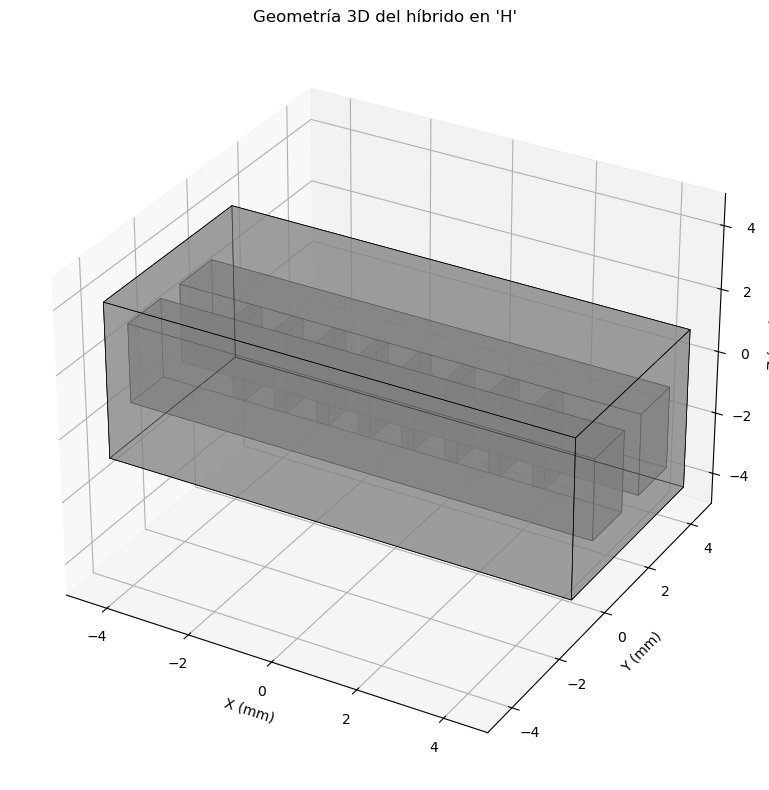

In [107]:
def draw_block(ax, center, size, color='gray', alpha=0.5):
    cx, cy, cz = center.x, center.y, center.z
    sx, sy, sz = size.x/2, size.y/2, size.z/2
    
    # Coordenadas de los vértices del cubo
    vertices = [
        [cx - sx, cy - sy, cz - sz],
        [cx + sx, cy - sy, cz - sz],
        [cx + sx, cy + sy, cz - sz],
        [cx - sx, cy + sy, cz - sz],
        [cx - sx, cy - sy, cz + sz],
        [cx + sx, cy - sy, cz + sz],
        [cx + sx, cy + sy, cz + sz],
        [cx - sx, cy + sy, cz + sz]
    ]
    
    # Caras del cubo
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
        [vertices[1], vertices[2], vertices[6], vertices[5]],  # right
        [vertices[0], vertices[3], vertices[7], vertices[4]],  # left
    ]
    
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, linewidths=0.5, edgecolors='k', alpha=alpha))

# ————————————————————————————————
# Visualización 3D de la geometría
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for obj in geometry:
    if isinstance(obj, mp.Block):
        draw_block(ax, obj.center, obj.size)

# Ajustamos título y etiquetas
ax.set_title("Geometría 3D del híbrido en 'H'")
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")

# — Ajuste de límites para que el cubo de ejes envuelva toda la geometría —
#margin = 0.2  # 20% de margen extra
#half_x = cell_x / 2
#half_y = cell_y / 2
#half_z = a / 2

ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)

plt.tight_layout()
plt.show()



     block, center = (0,0,0)
          size (11,5,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-1.005,0)
          size (11,1.27,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.005,0)
          size (11,1.27,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-0.5133,0,0)
          size (0.2866,0.74,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-1.5399,0,0)
          size (0.2866,0.74,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-2.5665,0,0)
          size (0.2866,0.74,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block

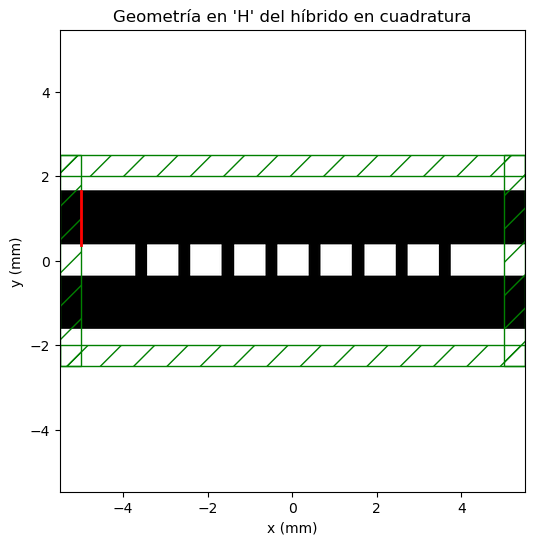

In [108]:
# vista 2D de la geometria del hibrido 
fig = plt.figure(figsize=(6,6))
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, 0)))
plt.title("Geometría en 'H' del híbrido en cuadratura")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.axis("equal")
plt.show()

In [113]:
flux_monitors = []
for reg in regions:
    flux_monitors.append( sim.add_flux(fcentral, df, nfreq, reg) )
    
# Monitores de campos, lo uso para la fase entre 

frecuencias = np.linspace(fminima, fmaxima, nfreq)

mon1 = sim.add_dft_fields([mp.Bz, mp.Ey], frecuencias,
                          where=mp.Volume(center=mp.Vector3( L/2, (b+d)/2,0),
                                         size=mp.Vector3(0,0,0)))
mon2 = sim.add_dft_fields([mp.Bz, mp.Ey], frecuencias,
                          where=mp.Volume(center=mp.Vector3( L/2, -(b+d)/2,0),
                                         size=mp.Vector3(0,0,0)))

# ahora ejecutamos la simulación (mantén tu sim.run original)
sim.run(until = 12)


FloatProgress(value=10.0, description='0% done ', max=22.0, min=10.0)

on time step 1000 (time=10), 22.406 s/step
Meep progress: 0.05000000000000071/22.0 = 0.2% done in 4.2s, 1823.7s to go
on time step 1005 (time=10.05), 0.830448 s/step
Meep progress: 0.09999999999999964/22.0 = 0.5% done in 8.3s, 1820.7s to go
on time step 1010 (time=10.1), 0.831828 s/step
Meep progress: 0.15000000000000036/22.0 = 0.7% done in 12.5s, 1813.8s to go
on time step 1015 (time=10.15), 0.82756 s/step
Meep progress: 0.20000000000000107/22.0 = 0.9% done in 16.6s, 1812.7s to go
on time step 1020 (time=10.2), 0.835684 s/step
Meep progress: 0.25/22.0 = 1.1% done in 20.9s, 1819.6s to go
on time step 1025 (time=10.25), 0.856782 s/step
Meep progress: 0.3000000000000007/22.0 = 1.4% done in 25.1s, 1818.9s to go
on time step 1030 (time=10.3), 0.846184 s/step
Meep progress: 0.34999999999999964/22.0 = 1.6% done in 29.3s, 1809.9s to go
on time step 1035 (time=10.35), 0.822536 s/step
Meep progress: 0.40000000000000036/22.0 = 1.8% done in 33.5s, 1807.8s to go
on time step 1040 (time=10.4), 0.84

     block, center = (0,0,0)
          size (11,5,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (-1e+20,-1e+20,-1e+20)
     block, center = (0,-1.005,0)
          size (11,1.27,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.005,0)
          size (11,1.27,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-0.5133,0,0)
          size (0.2866,0.74,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-1.5399,0,0)
          size (0.2866,0.74,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-2.5665,0,0)
          size (0.2866,0.74,2.54)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block

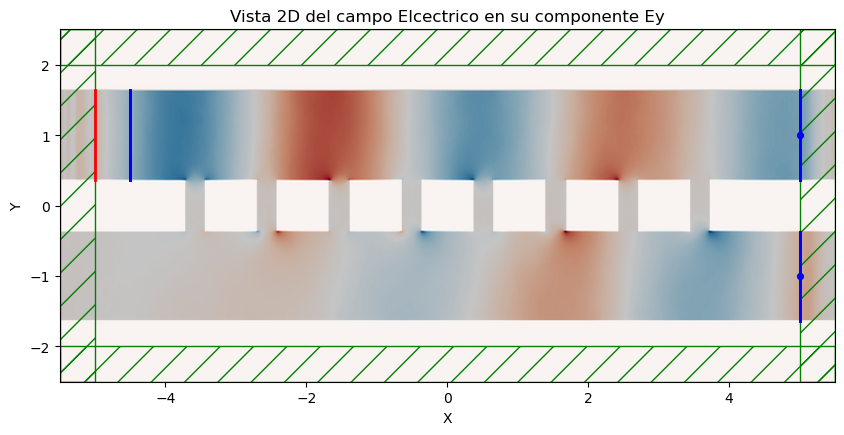

In [114]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, 0)),fields=mp.Ey) # cambiar entre Ey y Bz para ver lso diferentes campos 
plt.title("Vista 2D del campo Elcectrico en su componente Ey")
plt.show()

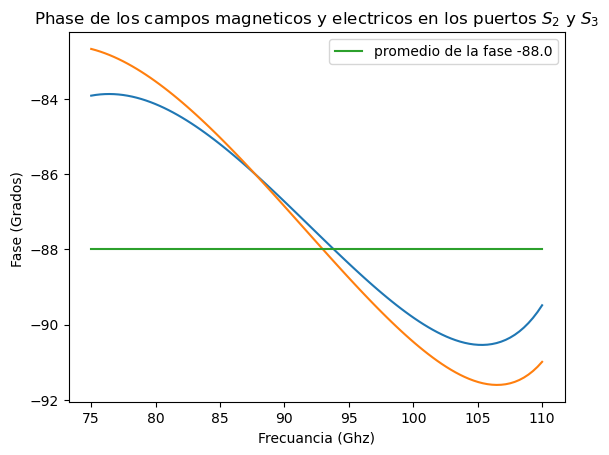

In [115]:
# Analisis de la diferencia de fase entre los puertos 2 y 3 
Ey1 = np.array([sim.get_dft_array(mon1, mp.Ey, i) for i in range(nfreq)])
Ey2 = np.array([sim.get_dft_array(mon2, mp.Ey, i) for i in range(nfreq)])
Bz1 = np.array([sim.get_dft_array(mon1, mp.Bz, i) for i in range(nfreq)])
Bz2 = np.array([sim.get_dft_array(mon2, mp.Bz, i) for i in range(nfreq)])
phaseElect = np.angle(Ey1/Ey2, deg=True) # datos a usar 
phaseMag = np.angle(Bz1/Bz2, deg=True)
meanfase = round(np.mean(phaseElect),0) 

# Grafico de Fase 

plt.plot(frecuencias*300,phaseMag)#, label = f"Fase del campo eléctrico")
plt.plot(frecuencias*300,phaseElect)#, label = f"Fase del campo mágnetico") #compruebo que solo necesito un campo para mi analisis dado este caso 
plt.plot(frecuencias*300,[meanfase]*len(frecuencias), label = f"promedio de la fase {meanfase}")
#plt.plot(frecuencias*300,[modafase]*len(frecuencias), label = f"moda de la fase {modafase}")
plt.legend()
plt.title(f"Phase de los campos magneticos y electricos en los puertos $S_2$ y $S_3$")
plt.xlabel("Frecuancia (Ghz)")
plt.ylabel("Fase (Grados) ");

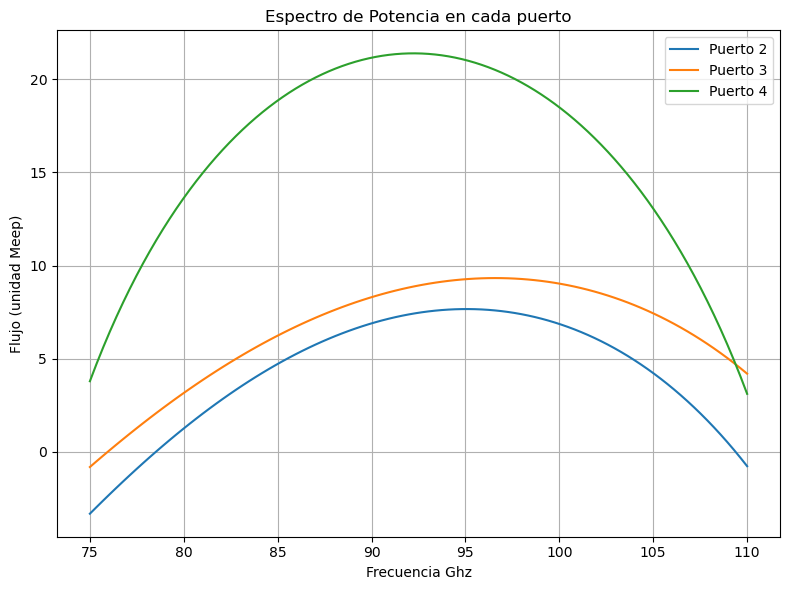

In [123]:

# --- EXTRAEMOS Y PLOTAMOS FLUJO VS LONGITUD DE ONDA ---
# obtenemos las frecuencias de muestreo
freqs = mp.get_flux_freqs(flux_monitors[0])

# recogemos los flujos de cada monitor
flux_data = np.array([ mp.get_fluxes(fm) for fm in flux_monitors ]) # dato a usar en la optimización

plt.figure(figsize=(8,6))
for i, flux in enumerate(flux_data):
    plt.plot(np.array(freqs)*300, 20*np.log10(flux), label=f'Puerto {2+i}')
#plt.plot(np.array(freqs)*300, 20*np.log10(flux_data[1]), label=f'Puerto 1')
plt.xlabel('Frecuencia Ghz')
plt.ylabel('Flujo (unidad Meep)')
plt.title('Espectro de Potencia en cada puerto')
plt.legend()
plt.gca()  # opcional: λ creciente a la izquierda
plt.grid(True)
plt.tight_layout()
plt.show()